In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import gower
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from tqdm import tqdm

In [2]:
df = pd.read_csv('data/clusters.csv').drop('Unnamed: 0', axis=1)
cluster = df[df.cluster==3]
print(cluster.shape)
cluster.head()

(8548, 26)


,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,track_id,artist_id
0,['Three Dog Night'],It Ain't Easy,0.465,0.629,166707,0.376,0,0.000000,7,0.2350,-13.934,1,26,0.0337,76.848,0.347,1970-01-01,1970,0.218438,0.254809,0.278542,0.113587,3,"['album rock', 'art rock', 'blues rock', 'bril...",2hKxnhi2Eb3443AQbOnqNl,4FAEZeJcsYYBkNq2D3KGTV
2,['Roberto Luti'],Celoso,0.840,0.526,158387,0.501,0,0.000000,0,0.1390,-8.088,1,39,0.0367,113.546,0.762,1970-08-28,1970,0.105862,0.246640,0.282148,0.086823,3,['pop romantico'],5FD1IZKwXVSL3zGwlNvLoF,33Cme6gMFRML19GrfipNMH
3,['Dionne Warwick'],Raindrops Keep Falling on My Head,0.908,0.691,179040,0.157,0,0.000007,1,0.0898,-13.711,1,36,0.0475,89.844,0.378,1970,1970,0.254998,0.290001,0.232987,0.151798,3,"['adult standards', 'brill building pop', 'dis...",5o5fCEeIGC8igGmbXQZL8Q,2JSjCHK79gdaiPWdKiNUNp
4,['Johnny Mathis'],Raindrops Keep Fallin' On My Head,0.908,0.609,149627,0.380,0,0.001520,5,0.0728,-10.527,1,31,0.0343,109.514,0.612,1970-02-25,1970,0.201921,0.248245,0.288763,0.138733,3,"['adult standards', 'brill building pop', 'eas...",6BZaceyM6nWzq0AUFcaEX1,21LGsW7bziR4Ledx7WZ1Wf
5,['John Cale'],Cleo,0.507,0.610,152627,0.672,0,0.000002,8,0.1250,-13.106,1,28,0.0401,121.486,0.952,1970,1970,0.167390,0.224980,0.256536,0.158433,3,"['alternative rock', 'art pop', 'art rock', 'c...",1KwgoiZwQGqyQN7rYKsgOw,5MWBg16f5UYiaSlyVhzlIW


# Preprocessing #

In [3]:
# create new data frame with only necessary features for modeling
model = cluster.drop(['artists', 'name', 'popularity', 'release_date', 'year', 'medoid_0', 'medoid_1', 'medoid_2', 
                      'medoid_3', 'cluster', 'genre', 'artist_id'], axis=1)
model.set_index('track_id', inplace=True)
print(model.shape)
model.head()

(8548, 13)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
track_id,,,,,,,,,,,,,
2hKxnhi2Eb3443AQbOnqNl,0.465,0.629,166707,0.376,0,0.000000,7,0.2350,-13.934,1,0.0337,76.848,0.347
5FD1IZKwXVSL3zGwlNvLoF,0.840,0.526,158387,0.501,0,0.000000,0,0.1390,-8.088,1,0.0367,113.546,0.762
5o5fCEeIGC8igGmbXQZL8Q,0.908,0.691,179040,0.157,0,0.000007,1,0.0898,-13.711,1,0.0475,89.844,0.378
6BZaceyM6nWzq0AUFcaEX1,0.908,0.609,149627,0.380,0,0.001520,5,0.0728,-10.527,1,0.0343,109.514,0.612
1KwgoiZwQGqyQN7rYKsgOw,0.507,0.610,152627,0.672,0,0.000002,8,0.1250,-13.106,1,0.0401,121.486,0.952


In [4]:
# create list for different types of features for access later
num_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
                'speechiness', 'tempo', 'valence']
cat_features = ['explicit', 'mode', 'key']

### Calculate Matrix of Similarities Between All Tracks ###

In [5]:
# create a list of cat_features indicators
cat_ind = [True if x in cat_features else False for x in model.columns]

gdf = gower.gower_matrix(model, cat_features=cat_ind)

In [6]:
gdf_model = pd.DataFrame(gdf, index=model.index)
print(gdf_model.shape)
gdf_model.head()

(8548, 8548)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,8523,8524,8525,8526,8527,8528,8529,8530,8531,8532,8533,8534,8535,8536,8537,8538,8539,8540,8541,8542,8543,8544,8545,8546,8547
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2hKxnhi2Eb3443AQbOnqNl,0.000000,0.170346,0.153905,0.155415,0.180611,0.171406,0.182200,0.164503,0.175721,0.090317,0.211465,0.144291,0.133863,0.167794,0.140081,0.215963,0.089275,0.089518,0.048376,0.131143,0.076395,0.079860,0.142752,0.212916,0.225740,...,0.133476,0.108585,0.216879,0.168039,0.237255,0.065113,0.156004,0.161795,0.116378,0.166838,0.144972,0.144972,0.144972,0.156309,0.166838,0.145506,0.110130,0.130724,0.190268,0.144846,0.168026,0.226186,0.140001,0.071324,0.120835
5FD1IZKwXVSL3zGwlNvLoF,0.170346,0.000000,0.158376,0.113470,0.133642,0.133090,0.032037,0.210153,0.177459,0.111394,0.223825,0.187591,0.129871,0.164183,0.169320,0.187359,0.167712,0.172157,0.160582,0.142865,0.132591,0.128208,0.071578,0.183946,0.207875,...,0.189634,0.156890,0.209328,0.231670,0.161907,0.154535,0.219259,0.151780,0.151684,0.150188,0.117638,0.117638,0.117638,0.132590,0.150188,0.112687,0.196875,0.182711,0.157953,0.195031,0.205762,0.099999,0.113718,0.163958,0.112705
5o5fCEeIGC8igGmbXQZL8Q,0.153905,0.158376,0.000000,0.125527,0.217300,0.115472,0.157702,0.223716,0.226698,0.144518,0.221560,0.187993,0.191496,0.111428,0.184091,0.169450,0.115818,0.174444,0.148853,0.135844,0.200237,0.189843,0.166907,0.221564,0.244008,...,0.177799,0.158216,0.181348,0.231926,0.231968,0.106127,0.208022,0.129914,0.082851,0.126407,0.186469,0.186469,0.186469,0.127961,0.126407,0.189787,0.145537,0.158399,0.227194,0.193535,0.210276,0.230585,0.181574,0.180712,0.171245
6BZaceyM6nWzq0AUFcaEX1,0.155415,0.113470,0.125527,0.000000,0.163040,0.047741,0.116369,0.216234,0.205623,0.105717,0.216726,0.186390,0.158254,0.133788,0.094881,0.175800,0.145755,0.174671,0.149654,0.145141,0.147196,0.160131,0.134115,0.173550,0.226757,...,0.097610,0.069947,0.187410,0.228044,0.239810,0.121450,0.218731,0.135008,0.158654,0.133500,0.188294,0.188294,0.188294,0.110723,0.133500,0.183583,0.171699,0.164303,0.224747,0.197501,0.205557,0.185306,0.176270,0.175921,0.181431
1KwgoiZwQGqyQN7rYKsgOw,0.180611,0.133642,0.217300,0.163040,0.000000,0.208386,0.162421,0.222012,0.144783,0.163160,0.238397,0.207204,0.131458,0.223418,0.186914,0.254168,0.241342,0.207978,0.188763,0.168336,0.138717,0.111509,0.156544,0.137942,0.252084,...,0.173390,0.154847,0.260395,0.138503,0.289943,0.201284,0.205788,0.206339,0.155372,0.221622,0.193808,0.193808,0.193808,0.180267,0.221622,0.184220,0.197089,0.178845,0.242085,0.211280,0.205679,0.218793,0.178429,0.163281,0.192689


# Modeling #

In [23]:
np.random.seed(3332)

# find k clusters
results_kmedoids1 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 8545,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids1[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:55<00:00, 47.03s/it]


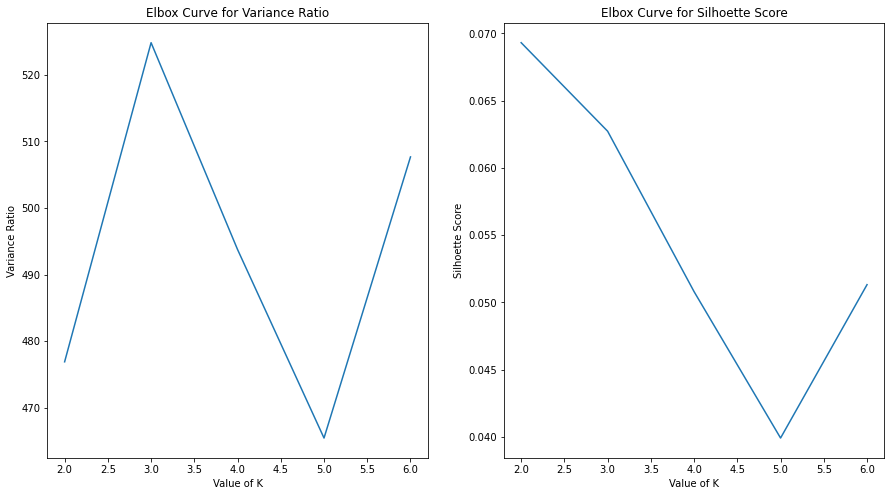

In [24]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids1.keys()],[i['v_ratio'] for i in results_kmedoids1.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids1.keys()],[i['s_score'] for i in results_kmedoids1.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [25]:
# save results for later and use in analysis notebook
results_all={}
results_all['model1'] = results_kmedoids1

In [26]:
np.random.seed(1411)

# find k clusters
results_kmedoids2 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids2[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [04:32<00:00, 54.58s/it]


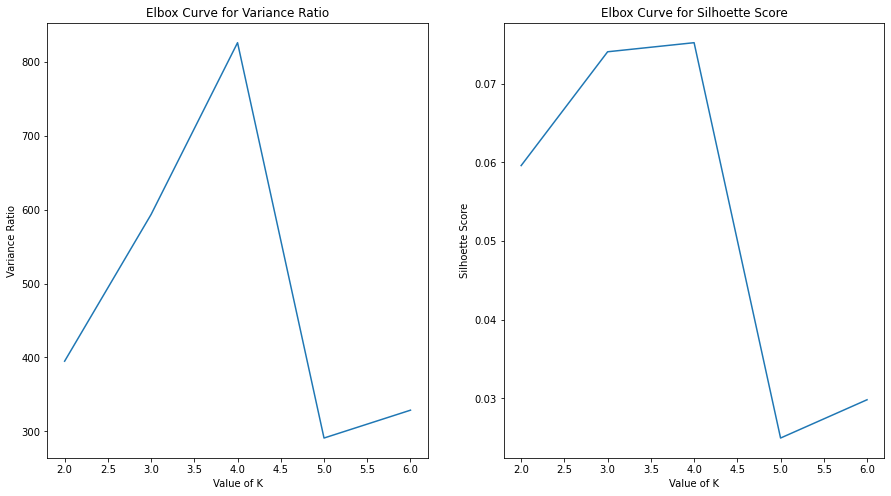

In [27]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids2.keys()],[i['v_ratio'] for i in results_kmedoids2.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids2.keys()],[i['s_score'] for i in results_kmedoids2.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [28]:
# save results for later and use in analysis notebook
results_all['model2'] = results_kmedoids2

In [29]:
np.random.seed(12)

# find k clusters
results_kmedoids3 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids3[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:12<00:00, 38.44s/it]


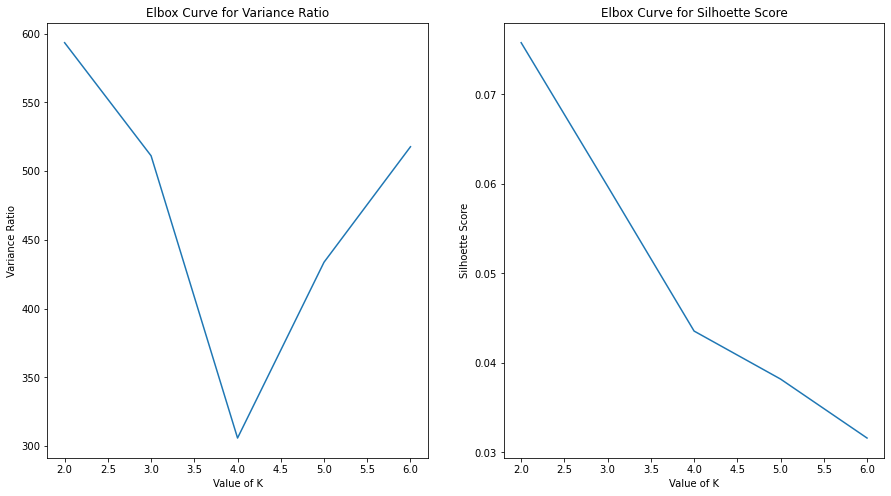

In [30]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids3.keys()],[i['v_ratio'] for i in results_kmedoids3.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids3.keys()],[i['s_score'] for i in results_kmedoids3.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [31]:
# save results for later and use in analysis notebook
results_all['model3'] = results_kmedoids3

In [32]:
np.random.seed(5511)

# find k clusters
results_kmedoids4 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids4[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:13<00:00, 38.64s/it]


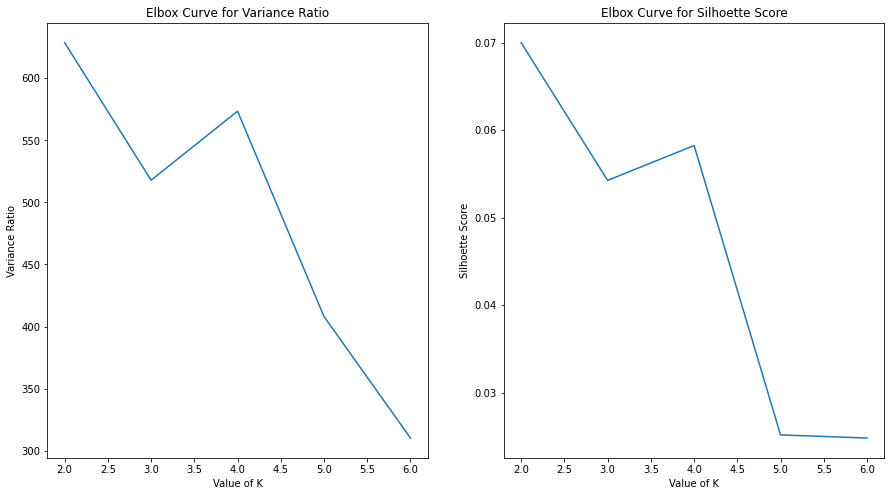

In [33]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids4.keys()],[i['v_ratio'] for i in results_kmedoids4.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids4.keys()],[i['s_score'] for i in results_kmedoids4.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [34]:
# save results for later and use in analysis notebook
results_all['model4'] = results_kmedoids4

In [35]:
np.random.seed(5411)

# find k clusters
results_kmedoids5 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids5[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:29<00:00, 41.84s/it]


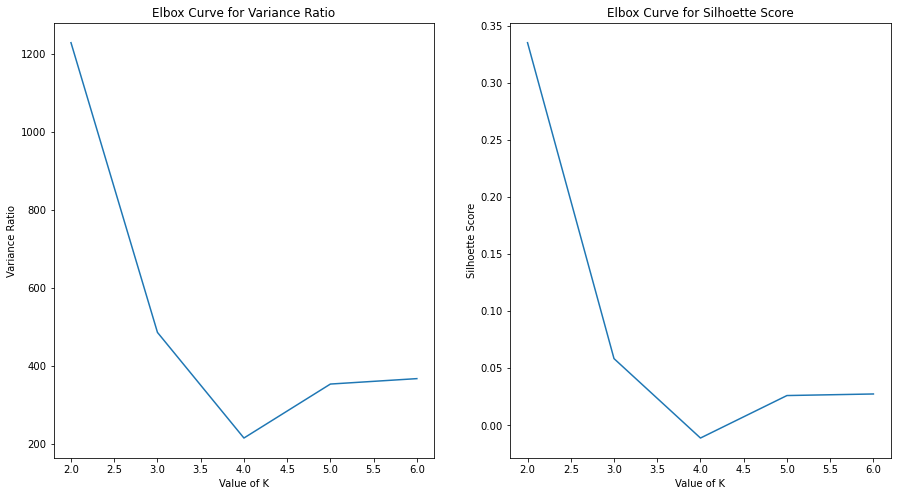

In [38]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids5.keys()],[i['v_ratio'] for i in results_kmedoids5.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids5.keys()],[i['s_score'] for i in results_kmedoids5.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [37]:
# save results for later and use in analysis notebook
results_all['model5'] = results_kmedoids5

Best model so far, k=2.

In [39]:
np.random.seed(30)

# find k clusters
results_kmedoids6 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids6[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:49<00:00, 45.97s/it]


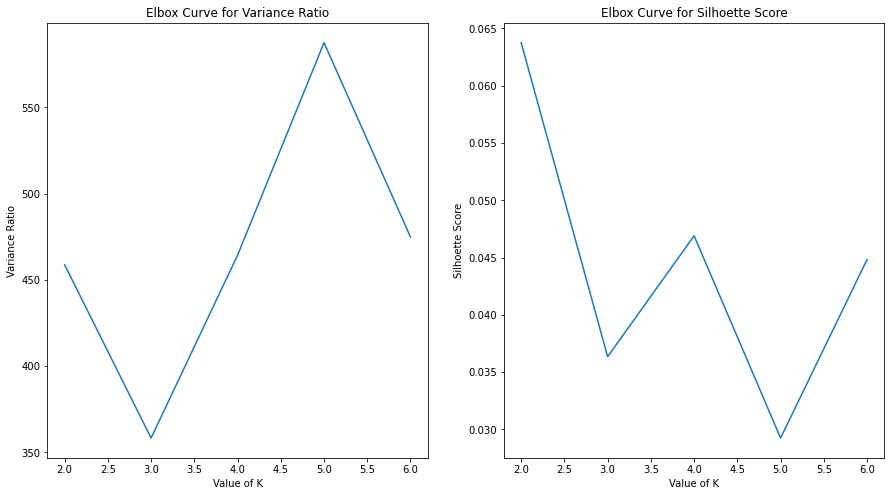

In [40]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids6.keys()],[i['v_ratio'] for i in results_kmedoids6.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids6.keys()],[i['s_score'] for i in results_kmedoids6.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [41]:
# save results for later and use in analysis notebook
results_all['model6'] = results_kmedoids6

In [42]:
np.random.seed(888)

# find k clusters
results_kmedoids7 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids7[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [05:06<00:00, 61.34s/it]


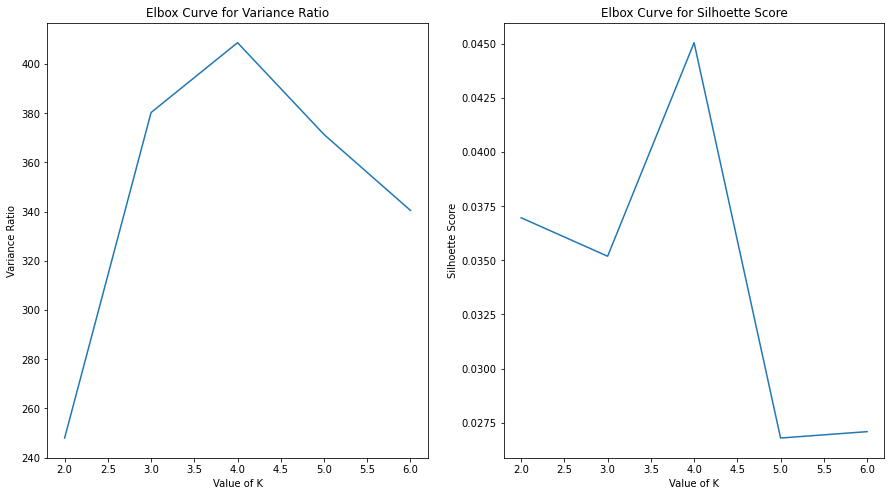

In [43]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids7.keys()],[i['v_ratio'] for i in results_kmedoids7.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids7.keys()],[i['s_score'] for i in results_kmedoids7.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [44]:
# save results for later and use in analysis notebook
results_all['model7'] = results_kmedoids7

In [45]:
np.random.seed(1560)

# find k clusters
results_kmedoids8 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids8[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [04:02<00:00, 48.47s/it]


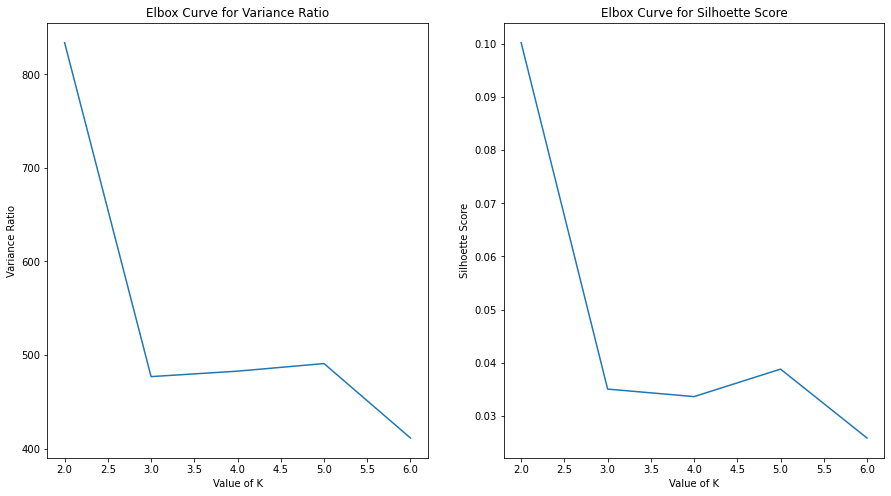

In [46]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids8.keys()],[i['v_ratio'] for i in results_kmedoids8.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids8.keys()],[i['s_score'] for i in results_kmedoids8.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [47]:
# save results for later and use in analysis notebook
results_all['model8'] = results_kmedoids8

In [48]:
np.random.seed(712)

# find k clusters
results_kmedoids9 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids9[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:24<00:00, 40.96s/it]


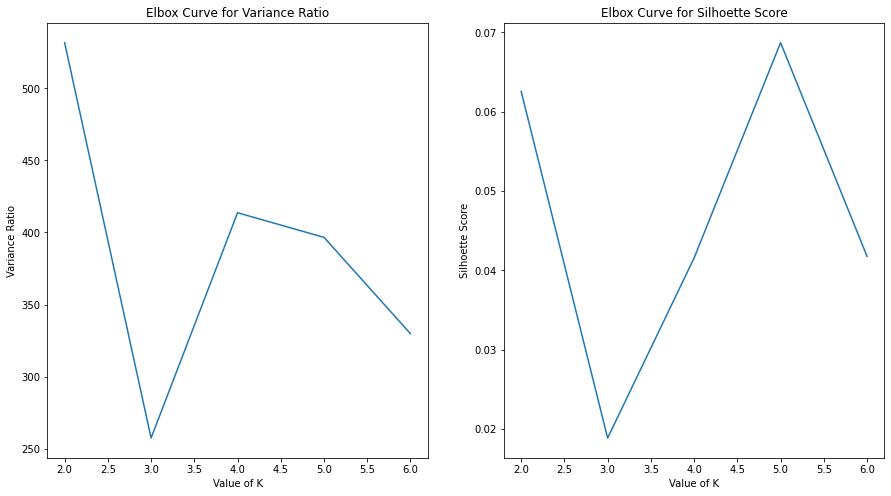

In [49]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids9.keys()],[i['v_ratio'] for i in results_kmedoids9.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids9.keys()],[i['s_score'] for i in results_kmedoids9.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [50]:
# save results for later and use in analysis notebook
results_all['model9'] = results_kmedoids9

In [51]:
np.random.seed(1733)

# find k clusters
results_kmedoids10 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids10[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:13<00:00, 38.79s/it]


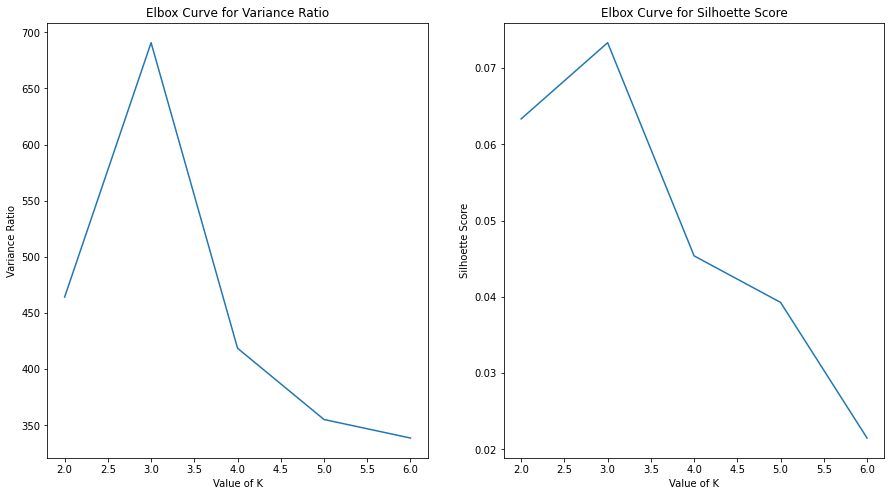

In [52]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids10.keys()],[i['v_ratio'] for i in results_kmedoids10.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids10.keys()],[i['s_score'] for i in results_kmedoids10.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [53]:
# save results for later and use in analysis notebook
results_all['model10'] = results_kmedoids10

# Conclusions #

Model 5 had the highest variance ratio at 1229.5 and silhoette score of .335. It was by far the superior model. 

In [54]:
results_all['model5'][2]

{'clusters': array([1, 1, 1, ..., 1, 1, 1]),
 'medoids': [758, 3077],
 'v_ratio': 1229.491058810974,
 's_score': 0.3350109}

In [55]:
# medoids for each subcluster
cluster.iloc[ ]

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,track_id,artist_id
2991,['Mélanie Laurent'],Début,0.990,0.377,160067,0.0239,0,0.88200,0,0.0998,-30.245,1,56,0.0403,119.263,0.0629,2011-05-02,2011,0.307096,0.437113,0.463300,0.214727,3,['french pop'],2g2Ggi6gqJiVD2knmkMEfM,7HS5tD2CPw2AgG4AgWpxpN
12320,['Neil Diamond'],Stones - Single Version,0.654,0.635,187733,0.2190,0,0.00135,0,0.0990,-20.711,1,25,0.0304,112.292,0.3730,1974-03-01,1974,0.153545,0.265817,0.294561,0.046429,3,"['adult standards', 'brill building pop', 'fol...",7wWAzICaXdyRbbmTQUvzUH,7mEIug7XUlQHikrFxjTWes


The biggest differences in Cluster 3 was between acoustic, quiet tracks and completely instrumental/ambient tracks. These medoid/subcluster seem to capture that difference well. 

In [57]:
medoids = gdf_model.iloc[[758, 3077]].T
medoids['cluster2'] = results_all['model5'][2]['clusters']
medoids.columns = ['medoid2_0', 'medoid2_1', 'subcluster']
medoids.index = cluster.track_id

In [58]:
temp = cluster.set_index('track_id')
temp = temp.merge(medoids, left_index=True, right_index=True)

In [70]:
temp[temp.subcluster==0].sort_values('medoid2_0')[1:10]

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,artist_id,medoid2_0,medoid2_1,subcluster
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6YS1MXqso0zlmcL4OV1kXk,['Mélanie Laurent'],Début,0.990,0.377,160067,0.02390,0,0.882,0,0.0998,-30.245,1,57,0.0403,119.263,0.0629,2011-05-02,2011,0.307096,0.437113,0.463300,0.214727,3,['french pop'],7HS5tD2CPw2AgG4AgWpxpN,0.000000,0.142850,0
4Nf4pScvTosqe9xz0FCBui,['Penguin Cafe Orchestra'],Music For A Found Harmonium - 2008 Digital Rem...,0.915,0.382,219733,0.22500,0,0.921,0,0.0500,-12.962,1,39,0.0459,97.045,0.1030,1984,1984,0.265483,0.392589,0.421589,0.170355,3,"['bow pop', 'compositional ambient']",6rAZ6OYwAXqykSlPxqGy8E,0.010358,0.133116,0
3WoFKA49Hjdoj1O9yhV62c,['Ólafur Arnalds'],þÚ Ert Jörðin,0.982,0.208,274355,0.08470,0,0.931,0,0.1020,-20.917,1,55,0.0425,123.979,0.0391,2010-05-10,2010,0.303212,0.435367,0.458419,0.214294,3,"['bow pop', 'compositional ambient', 'icelandi...",7E3BRXV9ZbCt5lQTCXMTia,0.012341,0.178913,0
0YPagAr3GhXlRX06E4nUcw,['Ólafur Arnalds'],Tomorrow's Song,0.988,0.437,187848,0.04630,0,0.917,0,0.0845,-25.928,1,54,0.0369,140.478,0.1390,2011-12-05,2011,0.294978,0.428930,0.440268,0.205989,3,"['bow pop', 'compositional ambient', 'icelandi...",7E3BRXV9ZbCt5lQTCXMTia,0.018775,0.150071,0
7JGzUfmXJurpJabggwgtVP,['R.E.M.'],New Orleans Instrumental No. 1,0.980,0.309,135667,0.11000,0,0.862,0,0.0868,-21.111,1,45,0.0419,178.751,0.1330,1992-10-05,1992,0.304098,0.438050,0.449388,0.215926,3,"['alternative rock', 'classic rock', 'permanen...",4KWTAlx2RvbpseOGMEmROg,0.030206,0.178435,0
3Z44iTJ82FCCvupkymzuEp,['Danny Wright'],Somewhere In Time,0.892,0.242,283373,0.08460,0,0.782,0,0.1000,-19.026,1,47,0.0359,77.965,0.0713,2006-09-05,2006,0.295585,0.421514,0.451396,0.198529,3,"['calming instrumental', 'classify', 'new age'...",61iLE8UCtC0CquRuILASQm,0.031483,0.161274,0
010ALbbh5KlQ4fKWgSdhRd,['Mazzy Star'],Look On Down From The Bridge,0.642,0.370,287893,0.07720,0,0.690,0,0.1120,-19.322,1,59,0.0414,119.942,0.0954,1996-01-01,1996,0.240712,0.369768,0.394653,0.147424,3,"['alternative rock', 'dream pop', 'melancholia...",37w38cCSGgKLdayTRjna4W,0.032459,0.115090,0
0kcXC9u1P2PqAUCDfrU9CT,['Brian Eno'],Through Hollow Lands - 2004 Digital Remaster,0.983,0.330,236426,0.00729,0,0.938,0,0.0961,-30.602,1,28,0.0409,71.513,0.0538,1977-11-01,1977,0.337170,0.463566,0.493276,0.241226,3,"['ambient', 'art pop', 'art rock', 'compositio...",7MSUfLeTdDEoZiJPDSBXgi,0.032690,0.167166,0
3ZB8WOTt7p9cSia9iG0TMz,['Broadcast'],Echo's Answer,0.952,0.212,192000,0.21600,0,0.804,0,0.1070,-18.373,1,47,0.0426,80.370,0.0774,2000-03-20,2000,0.290233,0.417662,0.445315,0.193417,3,"['alternative rock', 'art pop', 'art rock', 'c...",0WtTGUjbur1R1cNzBvbsMU,0.034500,0.156351,0


In [65]:
temp[temp.subcluster==1].sort_values('medoid2_1').tail()

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,artist_id,medoid2_0,medoid2_1,subcluster
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1uzefoW8jYXUr4GGDUmPUM,['Hole'],Pretty On The Inside,0.390,0.120,88514,0.798,0,0.0027,9,0.5930,-9.415,1,36,0.0581,205.706,0.180,1991-01-01,1991,0.258147,0.333255,0.333163,0.257630,3,"['alternative rock', 'grunge', 'lilith', 'pop ...",5SHQUMAmEK5KmuSb0aDvsn,0.322560,0.263393,1
51PXL2lCvWSN41KhOcVdBE,"['Michael Jackson', 'Rod Temperton', 'Vincent ...",Voice-Over Intro / Voice-Over Session from Thr...,0.279,0.528,172360,0.453,0,0.0000,1,0.5930,-18.484,1,29,0.9600,75.676,0.436,1982-11-30,1982,0.295082,0.345507,0.284492,0.259345,3,"['pop', 'r&b', 'soul']",3fMbdgg4jU18AjLCKBhRSm,0.387580,0.265153,1
0QI38in0PP6LVZSl6NnKaI,['Juan Gabriel'],Amor Eterno (En Vivo) - En el Palacio de Bella...,0.162,0.257,428467,0.421,0,0.0000,9,0.9520,-11.296,1,55,0.0389,199.214,0.530,1990-12-25,1990,0.260669,0.325812,0.329124,0.258109,3,"['cancion melodica', 'latin', 'latin pop']",2MRBDr0crHWE5JwPceFncq,0.359928,0.268042,1
6OGjWY39HlMdrF5bNeikkG,['Yo La Tengo'],Center of Gravity,0.165,0.816,162307,0.356,0,0.6050,2,0.0706,-13.663,1,42,0.4540,159.592,0.968,1997-04-22,1997,0.277823,0.341049,0.329093,0.275904,3,"['alternative rock', 'anti-folk', 'art pop', '...",5hAhrnb0Ch4ODwWu4tsbpi,0.319796,0.279917,1
4Vp7PokYymcoThbUoA8sQX,['DMX'],Prayer - Skit,0.469,0.717,152133,0.186,1,0.0000,0,0.4600,-20.016,0,36,0.9390,102.082,0.213,1998-05-01,1998,0.417814,0.375337,0.378262,0.313783,3,"['east coast hip hop', 'gangster rap', 'hardco...",1HwM5zlC5qNWhJtM00yXzG,0.406294,0.297268,1


In [69]:
temp.subcluster.value_counts(normalize=True)

1    0.936359
0    0.063641
Name: subcluster, dtype: float64

While Subcluster 1 still houses the majority of the tracks, the instrumental/ambient tracks that Subcluster 0 captures makes them more distinct.

In [71]:
# export csv file
temp.to_csv('data/cluster3_subclusters.csv')